# Solución examen parcial 2

## Librerías que se usarán para resolver el ejercicio

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

## Parte 1: Hietograma de precipitación efectiva

El primer paso consiste en determinar el hietograma de precipitación efectiva para los escenarios sin y con intervención. Una aproximación es utilizar el método del número de curva directamente, o utilizar cualquier modelo de abstracción de infiltración.

**Escenario sin intervención:** 

Con los datos de textura del suelo es posible estimar los parámetros de varios modelos de infiltración. Aquí se va a utilizar el modelo de Green-Ampt.

Para un suelo franco-arcilloso (*clay loam*), los parámetros para el modelo según Rawls et al. (1983) son: $\phi$ = 0.464, $|\psi_{f}|$ = 20.88 cm, y $K_h$ = 0.10 cm/hr.

El déficit de humedad inicial $\Delta \theta$ se supone igual a la porosidad efectiva $\theta_e$, lo cual es equivalente a suponer que el contenido de humedad inicial en el suelo es igual al contenido de humedad residual $\theta_r$ (dado que es un problema de diseño, se está maximizando la capacidad de almacenamiento del suelo durante la condición sin intervención). Para un suelo franco-arcilloso, $\theta_e=0.309$.

**Escenario con intervención:**

En este escenario, el coeficiente de escorrentía $C$ es conocido. Teniendo en cuenta que dicho coeficiente es la relación entre la precipitación efectiva y la precipitacion total, se estima el umbral $\Phi$ de manera que la precipitación efectiva total sea igual a $C$ veces la precipitación total de la tormenta de diseño.

### Modelo de Green-Ampt (desarrollado a partir de Chow et al., 1988)

In [2]:
def infiltration(F, K, psi_f, delta_theta):
    if F == 0:
        f = np.inf
    else:
        f = K * (psi_f * delta_theta/F + 1)
    return f

def ponding_infiltration(w, K, psi_f, delta_theta):
    Fp = K * psi_f * delta_theta / (w - K)
    return Fp

def cum_infiltration(Fp, dt, K, psi_f, delta_theta):
    def func(x, dt, Fp, delta_theta, psi_f):
            x1 = abs(psi_f) * delta_theta + x
            x2 = abs(psi_f) * delta_theta + Fp
            x3 = K * dt
            return x - Fp - abs(psi_f) * delta_theta * np.log(x1/x2) - x3
        
    F = fsolve(func, x0 = Fp, args = (dt, Fp, delta_theta, psi_f))[0]
    return F

def solve_GreenAmpt(t, p, K, psi_f, delta_theta, dt=None, opt='linear'):
    
    P = np.cumsum(p) # precipitación acumulada (cm)
    w = np.diff(P)/np.diff(t) * (60) # intensidad (cm/h)
    
    if dt is not None:
        tnew = np.arange(t[0],t[-1],dt)
        
        if opt == 'linear':
            wnew = np.interp(tnew, t, np.hstack((w,0)))
        else:
            inds = np.digitize(tnew, t)
            wnew = np.array([w[ind-1] for ind in inds])
        
        t = np.hstack((tnew, t[-1]))
        w = wnew
        p = np.hstack((0, w*dt/60))
        P = np.cumsum(p)
    
    F = [0]
    f = [np.inf]

    F_old = F[0]
    f_old = f[0]
    
    for i in range(0, len(t) - 1):
        dt = (t[i+1] - t[i]) * (1/60)
        if f_old <= w[i]:
            F_new = cum_infiltration(F_old, dt, K, psi_f, delta_theta)
        else:
            F_temp = F_old + w[i] * dt
            f_temp = infiltration(F_temp, K, psi_f, delta_theta)
            if f_temp <= w[i]:
                Fp = ponding_infiltration(w[i], K, psi_f, delta_theta)
                dtp = (Fp - F_old) / w[i]
                F_new = cum_infiltration(Fp, dt - dtp, K, psi_f, delta_theta)
            else:
                F_new = F_temp

        f_new = infiltration(F_new, K, psi_f, delta_theta)

        F = F + [F_new]
        f = f + [f_new]

        F_old = F_new
        f_old = f_new
        
    F = np.array(F)
    f = np.array(f)
    
    Pe = P - F
    pe = np.diff(Pe)
    
    Pe[Pe<=1e-15] = 0
    pe[pe<=1e-15] = 0
    
    return pd.DataFrame({'t': t, 'p': p, 'P': P, 'i': np.hstack((w, 0)), 'f': f, 'F': F, 'Pe': Pe, 'pe': np.hstack((0, pe))})

### Datos del problema

In [3]:
t = [0,15,30,45,60,75,90,105,750] # tiempo (min)
p = [0,0.25,0.75,1.75,0.625,0.375,0.125,0,0] # precipitación incremental (cm)

K = 0.10 # Conductividad hidráulica (cm/hr)
psi_f = 20.88
delta_theta = 0.309

In [4]:
# Solución del modelo de Green-Ampt
ret = solve_GreenAmpt(t, p, K, psi_f, delta_theta, dt=15)
ret

,t,p,P,i,f,F,Pe,pe
0,0,0.000,0.000,1.0,inf,0.000000,0.000000,0.000000
1,15,0.250,0.250,3.0,2.680768,0.250000,0.000000,0.000000
2,30,0.750,1.000,7.0,1.109269,0.639267,0.360733,0.360733
3,45,1.750,2.750,2.5,0.835528,0.877182,1.872818,1.512085
4,60,0.625,3.375,1.5,0.704063,1.068088,2.306912,0.434094
5,75,0.375,3.750,0.5,0.623143,1.233299,2.516701,0.209789
6,90,0.125,3.875,0.0,0.575000,1.358299,2.516701,0.000000
7,105,0.000,3.875,0.0,0.575000,1.358299,2.516701,0.000000
8,120,0.000,3.875,0.0,0.575000,1.358299,2.516701,0.000000
9,135,0.000,3.875,0.0,0.575000,1.358299,2.516701,0.000000


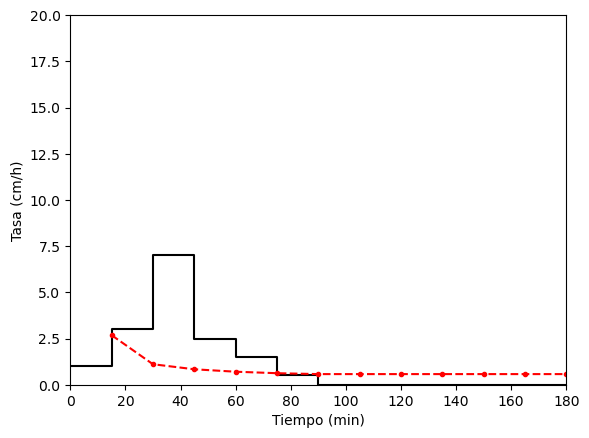

In [5]:
fig, axs = plt.subplots(1, 1)

axs.step(ret['t'], ret['i'], 'k', where='post')
axs.plot(ret['t'], ret['f'], 'r--.')
axs.set_ylim([0,20])
axs.set_xlim([0,180])
axs.set_xlabel('Tiempo (min)')
axs.set_ylabel('Tasa (cm/h)')
pass

### Hietograma a partir del coeficiente de escorrentía

In [6]:
def my_fun(x, t, p, C):
    pe = p - x
    pe[pe<0] = 0
    
    return C - np.sum(pe)/np.sum(p)

C = 0.75
p = ret['p']

umbral = fsolve(my_fun, x0 = 0, args = (t, p, C))[0]
pe = p - umbral
pe[pe < 0] = 0

pe_post = pe

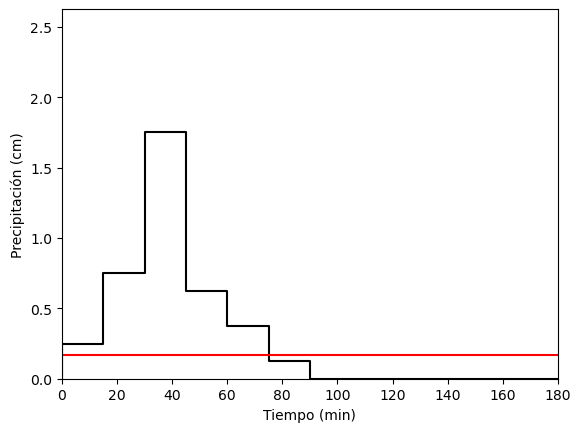

In [7]:
fig, axs = plt.subplots(1, 1)

axs.step(ret['t'], ret['p'], 'k', where='pre')
axs.hlines(y=umbral, xmin=t[0], xmax=t[-1], color='r')
axs.set_ylim([0, 1.5*np.max(ret['p'])])
axs.set_xlim([0,180])
axs.set_xlabel('Tiempo (min)')
axs.set_ylabel('Precipitación (cm)')
pass

Comparación de hietogramas de precipitación efectiva pre- y post- intervención (sin almacenamiento)

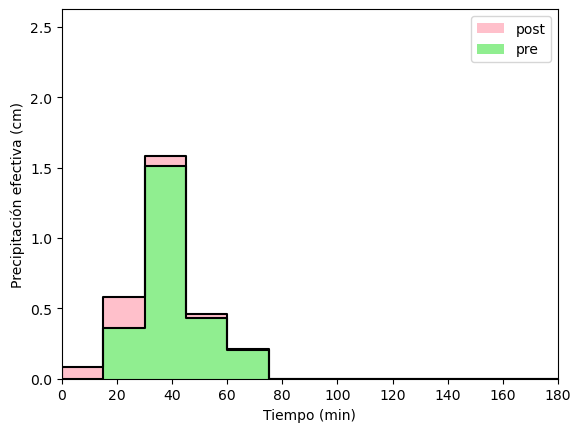

In [8]:
plt.step(ret['t'], ret['pe'], 'k-', where='pre')
plt.step(ret['t'], pe_post, 'k-', where='pre')
plt.fill_between(ret['t'], pe, step='pre', facecolor='pink', label = 'post')
plt.fill_between(ret['t'], ret['pe'], step='pre', facecolor='lightgreen', label = 'pre')
plt.legend()
plt.ylim([0, 1.5*np.max(ret['p'])])
plt.xlim([0, 180])
plt.xlabel('Tiempo (min)')
plt.ylabel('Precipitación efectiva (cm)')
pass

## Parte 2: Generación del hidrograma a la salida de la cuenca

Como se trata de una cuenca pequeña, es válido aplicar la teoría de sistemas lineales, particularmente el método del hidrograma unitario. Dado que no se cuenta con información de eventos, se puede optar por obtener un hidrograma unitario sintético. En el caso más simple, se puede derivar un hidrograma unitario instantáneo (IUH) suponiendo flujo superficial uniforme.

Una representación simple de la cuenca sin intervención puede ser como dos planos rectangulares inclinados drenando hacia un canal en el medio.

<img src="Planos.png" width="300"/>

El IUH para los planos rectangulares se puede obtener del diagrama de porcentaje acumulado de área generadora de escorrentía en función del tiempo, asumiendo una entrada instantánea de lluvia. El IUH corresponde a la derivada temporal de dicho diagrama. De forma similar, el IUH correspondiente al canal recibiendo una entrada lateral uniforme instantánea se deriva del diagrama de porcentaje de longitud acumulada del canal en función del tiempo. 

En ambos casos, la ecuación para el IUH se puede generalizar con un parámetro $k$ igual al inverso del tiempo de viaje de flujo superficial. En el caso de un único plano de dimensiones $L \times b$ con velocidad superficial $v_o$, el parámetro $k$ viene dado por $v_o/b$. Para dos planos inclinados con un canal en el medio (ver figura), $k = 2v_o/b$. Para el canal con velocidad uniforme $v_c$, el parámetro $k = v_c/L$. Se puede demostrar que el IUH en estos casos tiene la siguiente ecuación:

$$u(t) = k\left[g_1(t)-g_1 \left(t-\frac {1}{k}\right) \right]$$

siendo $g_1$ la función escalon unitario (función *heaviside*). Aplicando la ecuación de convolución, se puede obtener el IUH para toda la cuenca, tomando como entrada $I(\tau)$ el hidrograma unitario del área rectangular $u_o(t)$, y utilizando el IUH para el canal con entrada lateral uniforme e instantánea $u_c(t)$:

$$O(t) = \int_{0}^{t} I(\tau) u(t-\tau) \,d \tau $$

$$u_B(t) = \int_{0}^{t} u_o(\tau) u_c(t-\tau) \,d \tau $$

$$u_B(t) = k_o k_c \left\{ \frac {1}{k_c} - \max \left(0, \frac {1}{k_c} - t\right) + u_1 \left(t - \frac{1}{k_o} \right) \left[ \max \left(0, \frac {1}{k_o} + \frac {1}{k_c} - t \right) - \frac {1}{k_c} \right] \right\}$$

Donde $k_o$ y $k_c$ son los parámetros de IUH para el área rectangular y el canal, respectivamente.

#### Estimación de velocidades de flujo superficial (*overland flow*) y de canal

Para estimar las velocidades de flujo superficial y flujo en el canal, se pueden utilizar aproximaciones relativamente sofisticadas como onda cinemática o más simples como flujo uniforme. Por simplicidad, en este caso se aplicarán las siguientes ecuaciones utilizadas en el modelo SWAT, las cuales se derivan de la ecuación de resistencia de Manning:

$$v_o = 0.005 \frac {(B)^{0.4} S_o^{0.3}}{n^{0.6}} $$

$$v_c = 0.317 \frac {(B\times L)^{0.125} S_c^{0.375}}{n^{0.75}}$$

siendo B el ancho del área rectangular (igual a $b/2$ para calcular $v_o$ cuando se trata de un área con canal en el medio), $S_o$ y $S_c$ las pendientes del área lateral y del canal, respectivamente, y $n$ el coeficiente de rugosidad de Manning. 

De acuerdo con Engman (1983), los valores del $n$ de Manning para flujo superficial para pasto corto es 0.15. Para superficie impermeable se supondrá un valor de 0.015. Como no se cuenta con información de pendientes, se supone $S_o = S_c = 0.02$. Para la velocidad en el canal en el escenario con intervención, se supondrá un valor de 5 m/s, que es usado como velocidad máxima para ciertos materiales de tubería para alcantarillados.

La velocidad promedio de flujo superficial es 0.04 m/s
La velocidad promedio de flujo en el canal es 1.65 m/s


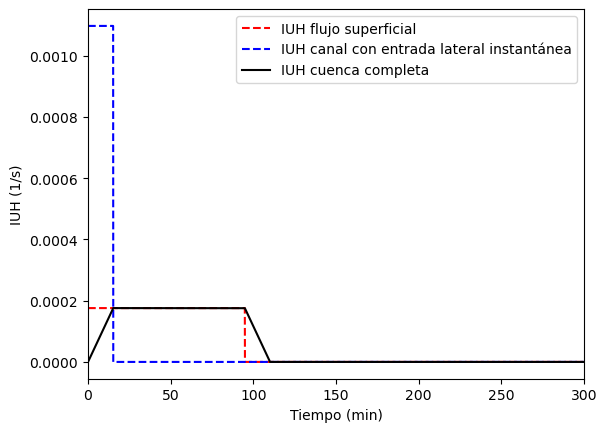

In [9]:
def iuh_basin(t, k1, k2):
    return k1 * k2 * (1/k2 - np.max((0, 1/k2 - t)) + np.heaviside(t - 1/k1, 1) * (np.max((0, 1/k1 + 1/k2 - t)) - 1/k2))

def iuh_generic(t, k):
    return k * (np.heaviside(t, 1) - np.heaviside(t - 1/k, 1))

''' Esta función no se usa ---
def area(t, v0, b, p):
    return v0/b * (b/v0 - np.max((0, p*b/v0 - t)) - np.max((0, (1-p)*b/v0 - t)))
'''

# Cálculo de velocidades - Escenario sin intervención
no = nc = 0.15
So = Sc = 0.02

b = 500
L = 1500

vo = 0.005 * (b/2)**0.4 * So**0.3 / no**0.6
vc = 0.317 * (b*L)**0.125 * Sc**0.375 / nc**0.75

print(f'La velocidad promedio de flujo superficial es {vo:2.2f} m/s')
print(f'La velocidad promedio de flujo en el canal es {vc:2.2f} m/s')

k1 = 2*vo/b
k2 = vc/L

ts = np.arange(t[0]*60,t[-1]*60, 1)
ub = u1 = u2 = []
for t_i in ts:    
    u = iuh_basin(t_i, k1, k2)
    uo = iuh_generic(t_i, k1)
    uc = iuh_generic(t_i, k2)
    
    u1 = u1 + [uo]
    u2 = u2 + [uc]
    ub = ub + [u]
    
ub = np.array(ub)
u1 = np.array(u1)
u2 = np.array(u2)

plt.plot(ts/60, u1, 'r--', label='IUH flujo superficial')
plt.plot(ts/60, u2, 'b--', label='IUH canal con entrada lateral instantánea')
plt.plot(ts/60, ub, 'k-', label='IUH cuenca completa')

plt.xlabel('Tiempo (min)')
plt.ylabel('IUH (1/s)')
plt.xlim([0,300])
plt.legend()
pass

### Respuesta de pulso unitario

Una vez conocido el IUH (respuesta de impulso), es necesario obtener la respuesta a un pulso unitario para generar el hidrograma de salida por el método del hidrograma unitario. La respuesta a un pulso unitario $h(t)$ se calcula así:

$$h(t) = \frac{1}{\Delta t} \left[g(t) - g(t-\Delta t) \right]$$

siendo $g(t)$ la respuesta de escalón, calculada así:

$$g(t) = \int_{0}^{t} u(\tau) d\tau$$

Para $0≤t≤\Delta t$, $g(t - \Delta t) = 0$. Por lo tanto:

$$h(t) = \frac{1}{\Delta t}\int_{t-\Delta t}^{t} u(\tau) d\tau$$

In [10]:
def escalon(t, k1, k2, dtau=1):
    tau = np.arange(0, t + dtau, dtau)
    g = 0
    for i,_ in enumerate(tau[:-1]):
        g = g + 0.5 * (iuh_basin(tau[i], k1, k2) + iuh_basin(tau[i+1], k1, k2)) * dtau
    return g

def pulso_unitario(t, dt, k1, k2, dtau=1):
    g1 = escalon(t, k1, k2, dtau)
    if (t - dt) >= 0:
        g2 = escalon(t-dt, k1, k2, dtau)
    else:
        g2 = 0
    
    return 1/dt * (g1 - g2)

#### Hidrograma de salida - escenario sin intervención

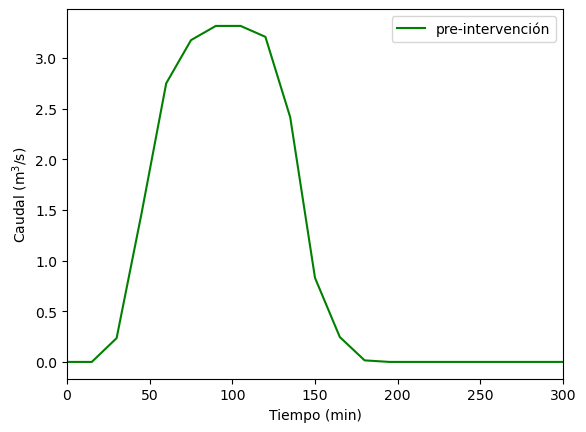

In [11]:
def hidrograma_unitario(U, pe, A):
    U = np.array([u  for u in U if u>0]).reshape((-1,1))
    P = np.zeros((len(pe),len(pe)))

    for i, p_i in enumerate(pe):
        P = P + np.diag([p_i for _ in range(0,len(pe) - i)], -i)  

    P = P[:,0:len(U)]
    Q = np.matmul(P,U) * A * (1/100)
    
    return Q

dtau = 60                                                       # paso de tiempo de integración (s)
dt = np.diff(ret['t'])[0]*60                                    # paso de tiempo del hietograma (s)
t = ret['t'] * 60                                               # vector de tiempos (s)
A = L * b                                                       # área de la cuenca (m2)
pe = ret['pe']                                                  # precipitación efectiva obtenida del método de abstracciones
U = [pulso_unitario(t_i, dt, k1, k2, dtau=dtau) for t_i in t]   # hidrograma de respuesta de pulso unitario
Q0 = hidrograma_unitario(U, pe, A)                              # hidrograma de salida obtenido con el método de hidrograma unitario

plt.plot(t/60,Q0,'g-',label='pre-intervención')
plt.xlim([0,300])
plt.xlabel('Tiempo (min)')
plt.ylabel('Caudal (m$^3$/s)')
plt.legend()
pass

#### Hidrograma de salida - escenario con intervención

En este caso, el área de estudio se subdivide en áreas aferentes mas pequeñas que drenan hacia los tramos de tubería especificados en el problema. Los hidrogramas generados a la salida de cada área aferente son luego trasladados hacia la salida de la cuenca a través de un canal lineal y sumados entre sí, siguiendo la teoría de sistemas lineales. A continuación se presenta la definición de áreas aferentes para el problema de diseño:

<img src="division.png" width="600"/>

En la figura anterior se pueden distinguir tres "tipos" de áreas aferentes, así:

|Tipo de área| Ancho (m) | Largo (m) | $k_o$           |
|------------|-----------|-----------|-----------------|
|1 (amarillo)|250        |250        | $\frac{v_o}{b}$ |
|2 (verde)   |500        |250        | $\frac{2v_o}{b}$|
|3 (azul)    |500        |250        | $\frac{v_o}{b}$ |

Para cada una de las áreas, la distancia $L_{out}$ hasta la salida para definir el tiempo de traslación $T=L_{out}/v_c$ (retraso en el canal lineal) viene dada de acuerdo con la siguiente tabla:

|Área  | $L_{out}$ (m) |
|------|---------------|
|A1    |1500           |
|A2    |1500           |
|A3    |1000           |
|A4    |1000           |
|A5    |500            |
|A6    |500            |
|A7    |500            |
|A8    |500            |

In [12]:
def canal_lineal(t, I, tau):
    O = []
    c = 0
    for i, (t_i, I_i) in enumerate(zip(t,I)):
        if (t_i - tau) <= 0:
            out_i = I[c]
        else:
            c += 1
            out_i = I[c]
        O = O + [out_i]
    O = np.array(O)
    return O

In [13]:
pe = pe_post

no = 0.015
So = 0.02
vc = 5 # velocidad máxima alcantarillado (m/s)

# Área tipo 1

b = 250
L = 250

vo = 0.005 * (b)**0.4 * So**0.3 / no**0.6

k1 = vo/b
k2 = vc/L

U = [pulso_unitario(t_i, dt, k1, k2, dtau=dtau) for t_i in t]

A = L * b
Q1 = hidrograma_unitario(U, pe, A)

# Área tipo 2

b = 500
L = 250

vo = 0.005 * (b/2)**0.4 * So**0.3 / no**0.6

k1 = 2*vo/b
k2 = vc/L

U = [pulso_unitario(t_i, dt, k1, k2, dtau=dtau) for t_i in t]

A = L * b
Q2 = hidrograma_unitario(U, pe, A)

# Área tipo 3

b = 500
L = 250

vo = 0.005 * (b)**0.4 * So**0.3 / no**0.6

k1 = vo/b
k2 = vc/L

U = [pulso_unitario(t_i, dt, k1, k2, dtau=dtau) for t_i in t]

A = L * b
Q3 = hidrograma_unitario(U, pe, A)

In [14]:
# Cálculo del caudal a la salida
vc = 5

O1 = canal_lineal(t*60,Q1,1500/vc)
O2 = canal_lineal(t*60,Q1,1500/vc)
O3 = canal_lineal(t*60,Q2,1000/vc)
O4 = canal_lineal(t*60,Q2,1000/vc)
O5 = canal_lineal(t*60,Q1,500/vc)
O6 = canal_lineal(t*60,Q1,500/vc)
O7 = canal_lineal(t*60,Q3,500/vc)
O8 = canal_lineal(t*60,Q3,500/vc)

O = O1 + O2 + O3 + O4 + O5 + O6 + O7 + O8

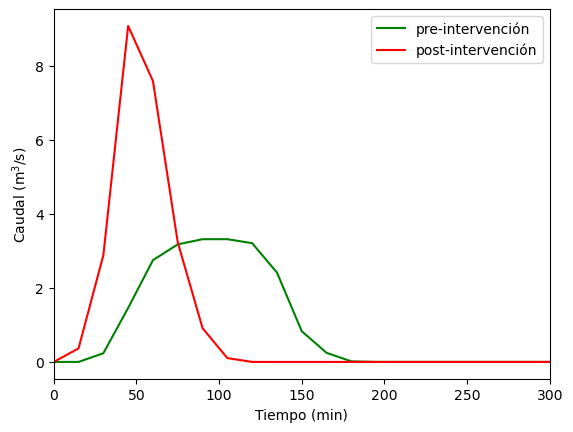

In [15]:
# Comparación hidrogramas pre- y post-intervención
plt.plot(t/60,Q0,'g-',label='pre-intervención')
plt.plot(t/60,O,'r-',label='post-intervención')
plt.xlabel('Tiempo (min)')
plt.ylabel('Caudal (m$^3$/s)')
plt.xlim([0,300])
plt.legend()
pass

### Parte 3: Dimensionamiento del volumen de almacenamiento

El objetivo principal del problema es dimensionar un almacenamiento de manera que el caudal pico a la salida coincida con el pico pre-intervención. Para ello, se aplicará un embalse lineal cuya entrada es el hidrograma de caudal post-intervención. 

El parámetro $K$ del modelo de embalse lineal, el cual es el tiempo de residencia, se determina de forma iterativa. El volumen de almacenamiento $S$ se obtiene así:

$$S= K\times \max{O(t)}$$

El valor anterior debe ser aproximadamente igual al área entre los hidrogramas de entrada y salida.

Es importante anotar que el aporte de las aguas residuales debe incluirse en el hidrograma de salida dado que se trata de un alcantarillado combinado. Dicho caudal se calcula así:

$$Q_{ar} = k_r \times q_d \times pob$$

siendo $pob$ la población, $q_d$ la dotación de diseño, y $k_r$ el factor de retorno.

In [16]:
# Cálculo de caudal de aguas residuales
pob = 1000 # habs
kr = 0.8
qd = 200 #L/hab/d

Qar = kr * pob * qd * (1/1000) * (1/(3600*24))
Oc = O + Qar
print(f'El caudal de aguas residuales a la salida del área es {Qar:2.5f} m3/s')

El caudal de aguas residuales a la salida del área es 0.00185 m3/s


In [17]:
def embalse_lineal(t, dt, k):
    if t <= dt:
        h = 1/dt * (1 - np.exp(-t/k))
    else:
        h = np.exp(-t/k) / dt * (np.exp(dt/k) - 1)
    
    return h

def hidrograma_unitario(U, pe):
    U = np.array([u  for u in U if u>0]).reshape((-1,1))
    P = np.zeros((len(pe),len(pe)))

    for i, p_i in enumerate(pe):
        P = P + np.diag([p_i[0] for _ in range(0,len(pe) - i)], -i)  

    P = P[:,0:len(U)]
    Q = np.matmul(P,U)
        
    return Q

def my_fun(x, dt, t, O, Op):
    U = [embalse_lineal(t_i, dt, x) for t_i in t]
    Oe = hidrograma_unitario(U, O)
    return Op - np.max(Oe)

In [18]:
K = fsolve(my_fun, x0=1, args=(dt/dt, t/dt, Oc*dt, np.max(Q0)*dt))[0]
print(f'El tiempo de residencia es {K*dt:3.1f} s')

El tiempo de residencia es 4135.1 s


El volumen de almacenamiento debe ser 13716.2 m^3


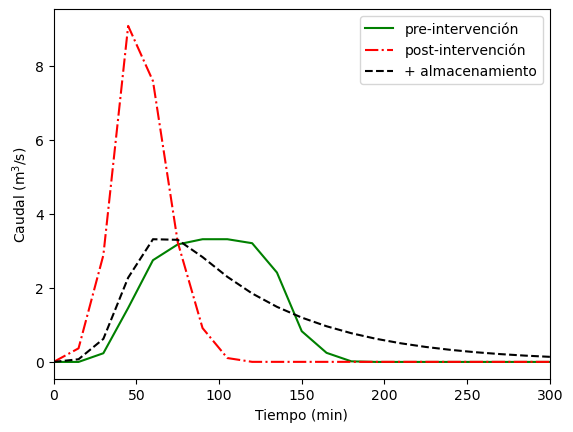

In [19]:
U = [embalse_lineal(t_i/dt, dt/dt, K) for t_i in t]
O2 = hidrograma_unitario(U, Oc*dt)/dt

S = K*dt*np.max(O2)
print(f'El volumen de almacenamiento debe ser {S:5.1f} m^3')

# Comparación hidrogramas pre- y post-intervención
plt.plot(t/60,Q0,'g-',label='pre-intervención')
plt.plot(t/60,Oc,'r-.',label='post-intervención')
plt.plot(t/60,O2,'k--',label='+ almacenamiento')

plt.xlim([0,300])
plt.xlabel('Tiempo (min)')
plt.ylabel('Caudal (m$^3$/s)')
plt.legend()
pass

#### Verificación del cálculo del volumen

In [20]:
# Interporlar series de salida en pasos de tiempo mas pequeños
dl = 1/60
t_int = np.arange(t.tolist()[0], t.tolist()[-1] + dl, dl)
Oc_int = np.interp(t_int,t,Oc.reshape((1,-1))[0])
O2_int = np.interp(t_int,t,O2.reshape((1,-1))[0])

diff = Oc_int - O2_int
diff = diff[diff>=0]
Sref = np.trapz(diff, dx=dl)
print(f'El volumen calculado a partir de los hidrogramas de entrada y salida es {Sref:5.1f} m^3')

El volumen calculado a partir de los hidrogramas de entrada y salida es 12247.6 m^3
